In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product

## **Processing of the dataset**

In [69]:
%run dataset.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed with RDP.
Data saved as 'processed_data_rdp.csv'.


In [70]:
data = pd.read_csv('data/processed_data_rdp.csv', index_col=0)
data.head()

,Close,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,,
2005-02-01,1189.410034,9.251176,1.797314,-0.549336,-0.070571,-1.054000,1.480793
2005-02-02,1193.189941,11.402198,1.628523,0.722583,0.862218,0.432633,0.686745
2005-02-03,1189.890015,7.089487,1.306029,1.231909,0.184395,0.519542,0.642527
2005-02-04,1203.030029,17.700814,2.703699,3.010612,2.172498,1.274530,0.414279
2005-02-07,1201.719971,14.341911,1.731183,3.262726,1.452061,1.309236,0.390989


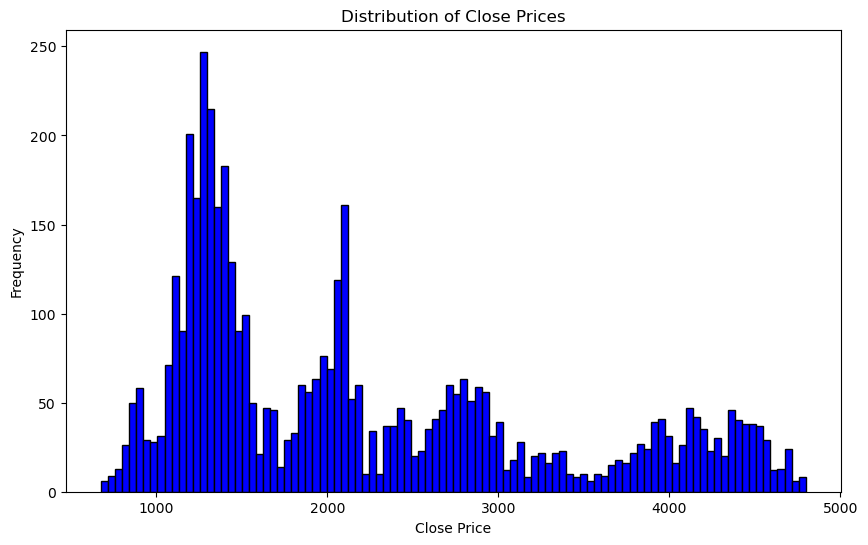

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

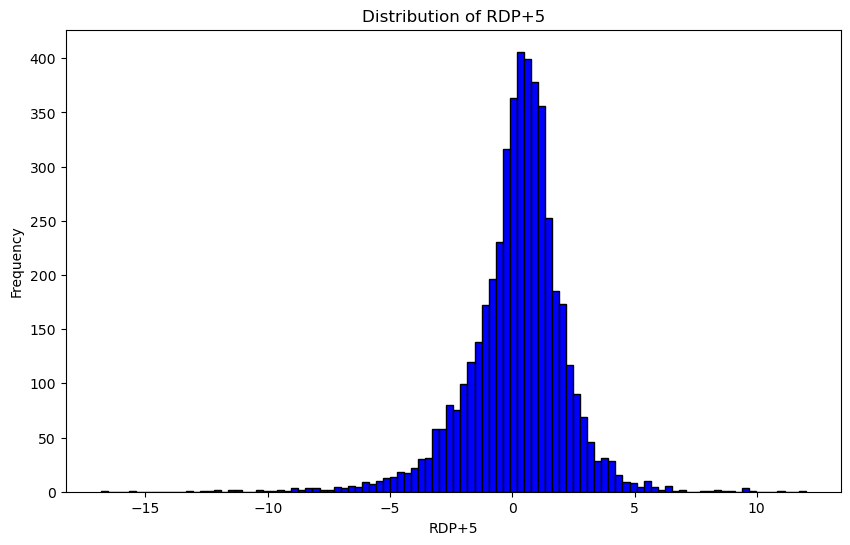

In [72]:
plt.figure(figsize=(10, 6))
plt.hist(data['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

### **Outliers**

In [73]:
def handle_outliers(dataframe, columns):
    """
    Replace outliers in specified columns with the closest marginal value.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to process.
    - columns (list): List of column names to apply outlier handling.
    
    Returns:
    - pd.DataFrame: DataFrame with outliers replaced.
    """
    for col in columns:
        mean = dataframe[col].mean()
        std_dev = dataframe[col].std()
        upper_limit = mean + 2 * std_dev
        lower_limit = mean - 2 * std_dev
        
        dataframe[col] = np.where(dataframe[col] > upper_limit, upper_limit, dataframe[col])
        dataframe[col] = np.where(dataframe[col] < lower_limit, lower_limit, dataframe[col])
    
    return dataframe

def scale_columns(dataframe, columns):
    """
    Scale the specified columns of a DataFrame to the range [-0.9, 0.9].

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names to scale.

    Returns:
    - pd.DataFrame: DataFrame with scaled columns.
    """
    scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
    dataframe[columns] = scaler.fit_transform(dataframe[columns])
    return dataframe

In [74]:
data_scaled = handle_outliers(data, columns=['RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = scale_columns(data_scaled, columns=['EMA15','RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = data_scaled.drop(columns=['Close'])
print(data_scaled.shape)
data_scaled.head()

(4756, 6)


,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,
2005-02-01,0.427594,0.298879,-0.122540,-0.065974,-0.171376,0.288841
2005-02-02,0.433592,0.267746,0.051282,0.038701,-0.024821,0.114253
2005-02-03,0.421567,0.208264,0.120888,-0.037362,-0.016253,0.104530
2005-02-04,0.451154,0.466056,0.363968,0.185738,0.058175,0.054345
2005-02-07,0.441788,0.286682,0.398423,0.104892,0.061596,0.049224


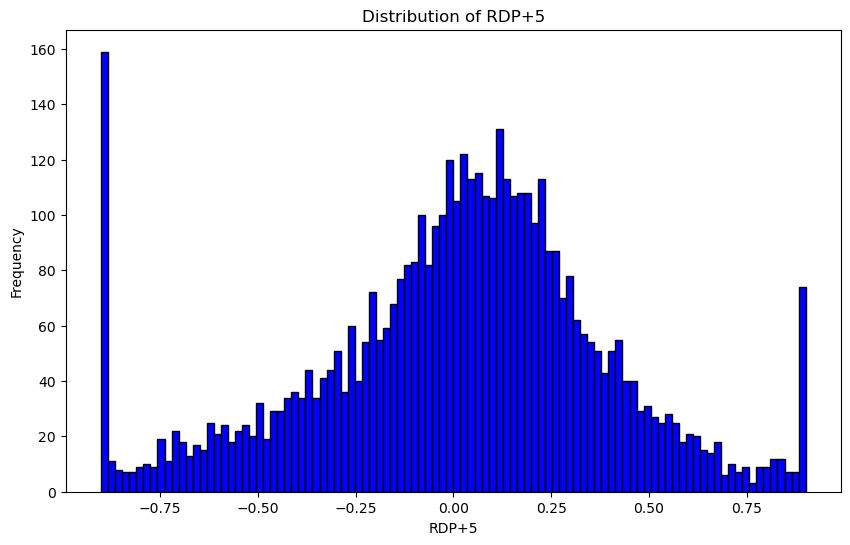

In [75]:
plt.figure(figsize=(10, 6))
plt.hist(data_scaled['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

## Splitting the data into Training-Validation-Testing

In [76]:
def split_data(dataframe, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data into training, validation, and testing sets.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame to split.
    - train_ratio (float): Proportion of data for training (default: 0.7).
    - val_ratio (float): Proportion of data for validation (default: 0.15).

    Returns:
    - tuple: (train_data, val_data, test_data)
    """
    train_end = int(len(dataframe) * train_ratio)
    val_end = train_end + int(len(dataframe) * val_ratio)

    train_data = dataframe[:train_end]
    val_data = dataframe[train_end:val_end]
    test_data = dataframe[val_end:]

    return train_data, val_data, test_data

In [77]:
train_data, val_data, test_data = split_data(data_scaled)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Testing data: {test_data.shape}')

Training data: (3329, 6)
Validation data: (713, 6)
Testing data: (714, 6)


In [78]:
features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']
target = 'RDP+5'

## **SVM Regression Model**

In [79]:
# SVM Regression Training and Evaluation
def train_and_evaluate_svm(train_data, val_data, test_data, features, target):
    """
    Train and evaluate an SVM regression model on the given data.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.

    Returns:
    - dict: A dictionary containing the model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features]
    y_train = train_data[target]

    X_val = val_data[features]
    y_val = val_data[target]

    X_test = test_data[features]
    y_test = test_data[target]

    # Train the SVR model
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)

    # Validate the model
    val_predictions = svr.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_nmse = val_mse / np.var(y_val)
    val_r2 = r2_score(y_val, val_predictions)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation NMSE: {val_nmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Test the model
    test_predictions = svr.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)
    test_r2 = r2_score(y_test, test_predictions)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test NMSE: {test_nmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Return results
    return {
        "model": svr,
        "val_predictions": val_predictions,
        "test_predictions": test_predictions,
        "y_test": y_test,
        "validation_metrics": {"mse": val_mse, "r2": val_r2, "nmse": val_nmse},
        "test_metrics": {"mse": test_mse, "r2": test_r2, "nmse": test_nmse},
    }

# Plot Predictions vs Actual Values
def plot_predictions(y_test, test_predictions, name_model,start_idx=0, end_idx=100):
    """
    Plot predictions vs actual values for a specified range.

    Parameters:
    - y_test (pd.Series): Actual target values from the test set.
    - test_predictions (np.ndarray): Predicted target values from the test set.
    - start_idx (int): Starting index for the range to plot.
    - end_idx (int): Ending index for the range to plot.
    """
    index = np.arange(abs(start_idx - end_idx))
    plt.figure(figsize=(10, 6))
    plt.plot(index, y_test.values[start_idx:end_idx], label='Actual Values', color='blue')
    plt.plot(index, test_predictions[start_idx:end_idx], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{name_model}: Predicted vs Actual')
    plt.xlabel('Index')
    plt.ylabel('RDP+5')
    plt.legend()
    plt.show()

Validation MSE: 0.1588
Validation NMSE: 0.9922
Validation R²: 0.0078
Test MSE: 0.1820
Test NMSE: 1.0480
Test R²: -0.0480


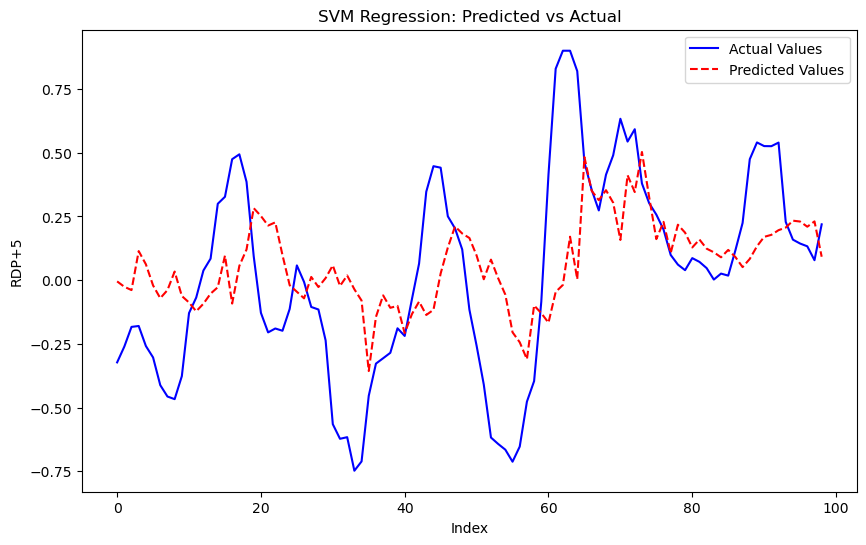

In [80]:
svr_results = train_and_evaluate_svm(train_data, val_data, test_data, features, target)
plot_predictions(svr_results['y_test'], svr_results['test_predictions'],name_model = "SVM Regression", start_idx=-100, end_idx=-1)

### **Optimisation of the Hyper-parameters**

In [81]:
from sklearn.model_selection import GridSearchCV

def optimize_svm(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVM hyperparameters using GridSearchCV.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary specifying hyperparameter ranges for GridSearchCV.

    Returns:
    - dict: Best hyperparameters and the optimized model.
    """
    # Combine training and validation sets for optimization
    combined_data = pd.concat([train_data, val_data])
    X_combined = combined_data[features]
    y_combined = combined_data[target]

    # Initialize the SVR model
    svr = SVR(kernel='rbf')

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    # Perform the grid search
    grid_search.fit(X_combined, y_combined)

    # Extract the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best hyperparameters: {best_params}")

    # Train the final model using the best hyperparameters
    best_model = grid_search.best_estimator_

    return {
        "best_model": best_model,
        "best_params": best_params,
        "grid_search": grid_search
    }

In [82]:
def optimize_svr_nmse(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVR hyperparameters using custom NMSE-based scoring.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary containing hyperparameter ranges for 'C', 'epsilon', and 'gamma'.

    Returns:
    - dict: Best SVR model, hyperparameters, and evaluation metrics.
    """
    # Extract hyperparameter ranges from param_grid
    C_values = param_grid.get("C", [1.0])
    epsilon_values = param_grid.get("epsilon", [0.1])
    gamma_values = param_grid.get("gamma", ["scale"])

    # Prepare training and validation data
    X_train = train_data[features].values
    y_train = train_data[target].values
    X_val = val_data[features].values
    y_val = val_data[target].values

    best_nmse = float('inf')
    best_params = None
    best_model = None

    # Iterate through all hyperparameter combinations
    for C, epsilon, gamma in product(C_values, epsilon_values, gamma_values):
        try:
            print(f"Evaluating SVR(C={C}, epsilon={epsilon}, gamma={gamma})...")
            model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
            model.fit(X_train, y_train)
            val_predictions = model.predict(X_val)

            # Calculate NMSE
            mse = mean_squared_error(y_val, val_predictions)
            nmse = mse / np.var(y_val)

            print(f"NMSE: {nmse:.4f}")

            if nmse < best_nmse:
                best_nmse = nmse
                best_params = {"C": C, "epsilon": epsilon, "gamma": gamma}
                best_model = model

        except Exception as e:
            print(f"SVR(C={C}, epsilon={epsilon}, gamma={gamma}) failed: {e}")

    val_predictions = best_model.predict(X_val)
    mse = mean_squared_error(y_val, val_predictions)
    r2 = r2_score(y_val, val_predictions)
    
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best NMSE: {best_nmse:.4f}")
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation R²: {r2:.4f}")

    return {
        "best_model": best_model,
        "best_params": best_params,
        "best_nmse": best_nmse,
        "mse": mse,
        "r2": r2
    }

In [83]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.1, 1, 10],
    "epsilon": [0.001, 0.01, 0.1],
    "gamma": [0.001 ,0.01, 0.1, 1]
}
# Optimize hyperparameters
svr_optimized_results = optimize_svr_nmse(train_data, val_data, features, target, param_grid)

# Evaluate the best model on the test set
best_model = svr_optimized_results["best_model"]
X_test = test_data[features]
y_test = test_data[target]
# Test the model
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test NMSE: {test_nmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.001)...
NMSE: 1.0012
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.01)...
NMSE: 0.9996
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.1)...
NMSE: 0.9923
Evaluating SVR(C=0.001, epsilon=0.001, gamma=1)...
NMSE: 0.9860
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.001)...
NMSE: 1.0010
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.01)...
NMSE: 0.9995
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.1)...
NMSE: 0.9922
Evaluating SVR(C=0.001, epsilon=0.01, gamma=1)...
NMSE: 0.9862
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.001)...
NMSE: 1.0014
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.01)...
NMSE: 0.9999
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.1)...
NMSE: 0.9929
Evaluating SVR(C=0.001, epsilon=0.1, gamma=1)...
NMSE: 0.9873
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.001)...
NMSE: 0.9909
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.01)...
NMSE: 0.9783
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.1)...
NMSE: 0.9669
Evaluating SVR(C=0.1, 

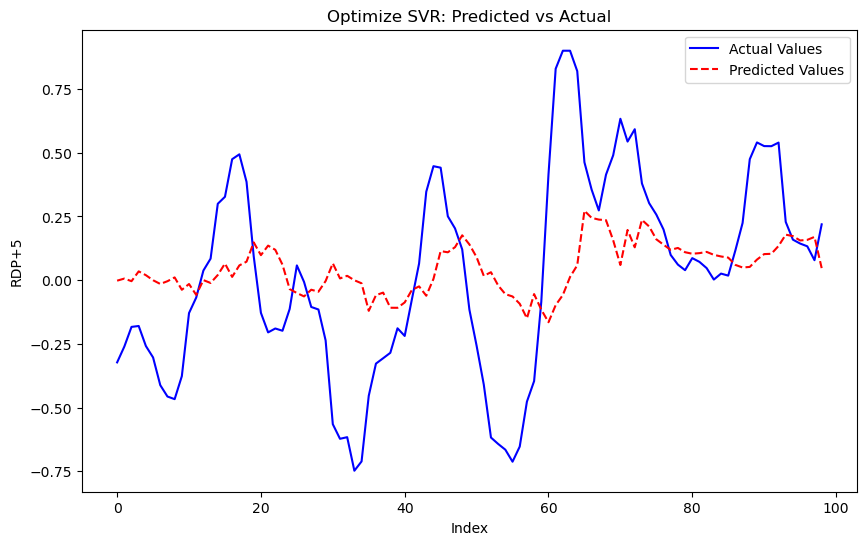

In [84]:
# Plot predictions for a specific range (e.g., last 100 data points)
plot_predictions(y_test, test_predictions, name_model="Optimize SVR",start_idx=-100, end_idx=-1)

## **Financial Time series (ARIMA/ARIMAX)**

In [85]:
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

In [86]:
def run_arima(train_data, test_data, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMA model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - target (str): Name of the target column.
    - order (tuple): ARIMA model order (p, d, q).

    Returns:
    - dict: ARIMA model, predictions, and evaluation metrics.
    """
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data))

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)

    print(f"ARIMA ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMA ({order}) Test R²: {r2:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2
    }

# ARIMAX Model
def run_arimax(train_data, test_data, exog_train, exog_test, order=(1, 1, 1)):
    """
    Fit and evaluate an ARIMAX model.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - exog_test (pd.DataFrame): Exogenous variables for testing.
    - target (str): Name of the target column.
    - order (tuple): ARIMAX model order (p, d, q).

    Returns:
    - dict: ARIMAX model, predictions, and evaluation metrics.
    """
    # Fit ARIMAX model
    model = SARIMAX(train_data, exog=exog_train, order=order)
    model_fitted = model.fit()

    # Predict on the test set
    predictions = model_fitted.forecast(steps=len(test_data), exog=exog_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data, predictions)
    r2 = r2_score(test_data, predictions)
    nmse = mse / np.var(test_data)

    print(f"ARIMAX ({order}) Test MSE: {mse:.4f}")
    print(f"ARIMAX ({order}) Test R²: {r2:.4f}")
    print(f"ARIMAX ({order}) Test NMSE: {nmse:.4f}")

    return {
        "model": model_fitted,
        "predictions": predictions,
        "mse": mse,
        "r2": r2,
        "nmse": nmse
    }

In [87]:
# Define target and exogenous features
target = 'RDP+5'
exogenous_features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']

# Split data
y_train = train_data[target]
y_val = val_data[target]
y_test = test_data[target]

X_train = train_data[exogenous_features]
X_val = val_data[exogenous_features]
X_test = test_data[exogenous_features]

ARIMA ((1, 1, 1)) Test MSE: 0.2280
ARIMA ((1, 1, 1)) Test R²: -0.3130


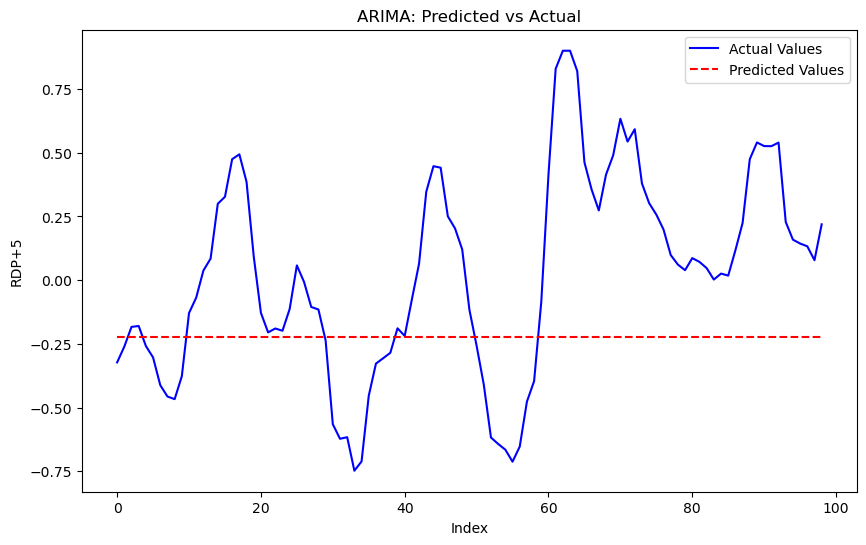

In [88]:
# Run ARIMA
arima_results = run_arima(y_train, y_test, order=(1, 1, 1))
arima_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arima_results['predictions'], name_model = "ARIMA", start_idx=-100, end_idx=-1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.00300D-01    |proj g|=  2.12161D-01


 This problem is unconstrained.



At iterate    5    f= -6.10528D-01    |proj g|=  1.75696D-02

At iterate   10    f= -6.11396D-01    |proj g|=  2.48601D-02

At iterate   15    f= -6.11930D-01    |proj g|=  1.64681D-03

At iterate   20    f= -6.11942D-01    |proj g|=  2.44617D-03

At iterate   25    f= -6.11945D-01    |proj g|=  3.37067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   3.371D-04  -6.119D-01
  F = -0.61194539179149499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMAX ((1, 1, 1)) Test MSE: 0.3938
ARIMAX ((1, 1, 1)) Test R²: -1.2678
ARIMAX ((1, 1, 1)) Test NMSE: 2.2678


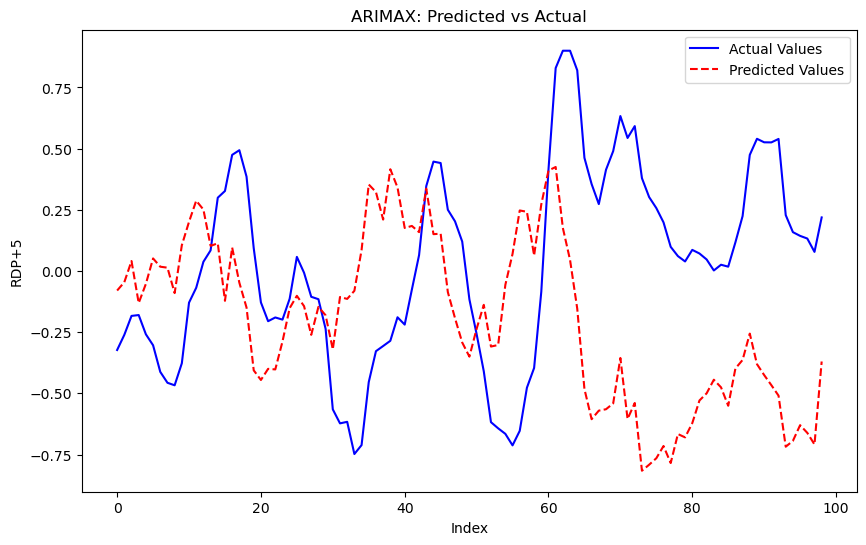

In [89]:
# Run ARIMAX
arimax_results = run_arimax(y_train, y_test, X_train, X_test, order=(1, 1, 1))
arimax_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arimax_results['predictions'], name_model = "ARIMAX", start_idx=-100, end_idx=-1)

In [90]:
# ARIMAX Optimization
def optimize_arimax(train_data, test_data, exog_train, exog_test, target, p_values, d_values, q_values):
    """
    Optimize the ARIMAX model by searching for the best combination of p, d, and q values.

    Parameters:
    - train_data (pd.Series): Training target data.
    - test_data (pd.Series): Testing target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - exog_test (pd.DataFrame): Exogenous variables for testing.
    - target (str): Name of the target column.
    - p_values (list): List of p values to try.
    - d_values (list): List of d values to try.
    - q_values (list): List of q values to try.

    Returns:
    - dict: Best ARIMAX model, its parameters, and evaluation metrics.
    """
    best_nmse = float('inf')
    best_order = None
    best_model = None

    for p, d, q in product(p_values, d_values, q_values):
        try:
            print(f"Evaluating ARIMAX({p},{d},{q})...")
            model = SARIMAX(train_data, exog=exog_train, order=(p, d, q))
            model_fitted = model.fit(disp=False)
            predictions = model_fitted.forecast(steps=len(test_data), exog=exog_test)
            nmse = mean_squared_error(test_data, predictions) / np.var(test_data)

            if nmse < best_nmse:
                best_nmse = nmse
                best_order = (p, d, q)
                best_model = model_fitted

        except Exception as e:
            print(f"ARIMAX({p},{d},{q}) failed: {e}")

    print(f"Best ARIMAX Order: {best_order} with MSE: {best_nmse:.4f}")
    
    y_pred = best_model.forecast(steps=len(test_data), exog=exog_test)
    r2 = r2_score(test_data, y_pred)
    mse = mean_squared_error(test_data, y_pred)
    
    print(f"Best ARIMAX Test R²: {r2:.4f}")
    print(f"Best ARIMAX Test NMSE: {nmse:.4f}")
    print(f"Best ARIMAX Test MSE: {mse:.4f}")
    print(f"Best ARIMAX Test R²: {r2:.4f}")
    
    return {
        "best_model": best_model,
        "best_order": best_order,
        "mse": mse,
        "r2": r2,
        "nmse": best_nmse
    }

In [103]:
def optimize_arimax(train_data, exog_train, val_data, exog_val, param_grid_arimax):
    """
    Optimize the ARIMAX model using a validation set and a parameter grid for hyperparameter tuning.

    Parameters:
    - train_data (pd.Series): Training target data.
    - exog_train (pd.DataFrame): Exogenous variables for training.
    - val_data (pd.Series): Validation target data.
    - exog_val (pd.DataFrame): Exogenous variables for validation.
    - param_grid_arimax (dict): Dictionary with lists of 'p_values', 'd_values', and 'q_values'.

    Returns:
    - dict: Best ARIMAX model, its parameters, and evaluation metrics.
    """
    # Extract p, d, q values from the parameter grid
    p_values = param_grid_arimax.get("p_values", [0])
    d_values = param_grid_arimax.get("d_values", [0])
    q_values = param_grid_arimax.get("q_values", [0])

    best_nmse = float('inf')
    best_order = None
    best_model = None

    # Iterate through all combinations of p, d, q
    for (p, d, q) in product(p_values, d_values, q_values):
        try:
            print(f"Evaluating ARIMAX({p},{d},{q})...")
            model = SARIMAX(train_data, exog=exog_train, order=(p, d, q))
            model_fitted = model.fit(disp=False)
            predictions = model_fitted.forecast(steps=len(val_data), exog=exog_val)
            nmse = mean_squared_error(val_data, predictions) / np.var(val_data)

            if nmse < best_nmse:
                best_nmse = nmse
                best_order = (p, d, q)
                best_model = model_fitted

        except Exception as e:
            print(f"ARIMAX({p},{d},{q}) failed: {e}")

    print(f"Best ARIMAX Order: {best_order} with Validation NMSE: {best_nmse:.4f}")
    
    mse = mean_squared_error(val_data, best_model.forecast(steps=len(val_data), exog=exog_val))
    r2 = r2_score(val_data, best_model.forecast(steps=len(val_data), exog=exog_val))
    
    return {
        "best_model": best_model,
        "best_order": best_order,
        "validation_nmse": best_nmse,
        "best_nmse": best_nmse,
        "mse": mse,
        "r2": r2
    }

In [104]:
# Optimize ARIMAX
param_grid_arimax = {
        "p_values": [1, 2, 3],
        "d_values": [0, 1],
        "q_values": [1, 2, 3]
    }

amimax_optimized_results = optimize_arimax(y_train, X_train, y_val, X_val, param_grid_arimax)

# Evaluate the final model on the test set
best_model = amimax_optimized_results['best_model']
test_predictions = best_model.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test NMSE: {test_nmse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

Evaluating ARIMAX(1,0,1)...
Evaluating ARIMAX(1,0,2)...
Evaluating ARIMAX(1,0,3)...
Evaluating ARIMAX(1,1,1)...
Evaluating ARIMAX(1,1,2)...
Evaluating ARIMAX(1,1,3)...
Evaluating ARIMAX(2,0,1)...
Evaluating ARIMAX(2,0,2)...
Evaluating ARIMAX(2,0,3)...
Evaluating ARIMAX(2,1,1)...
Evaluating ARIMAX(2,1,2)...
Evaluating ARIMAX(2,1,3)...
Evaluating ARIMAX(3,0,1)...
Evaluating ARIMAX(3,0,2)...
Evaluating ARIMAX(3,0,3)...
Evaluating ARIMAX(3,1,1)...
Evaluating ARIMAX(3,1,2)...
Evaluating ARIMAX(3,1,3)...
Best ARIMAX Order: (1, 1, 3) with Validation NMSE: 1.8384
Final Test MSE: 0.3356
Final Test NMSE: 1.9326
Final Test R²: -0.9326


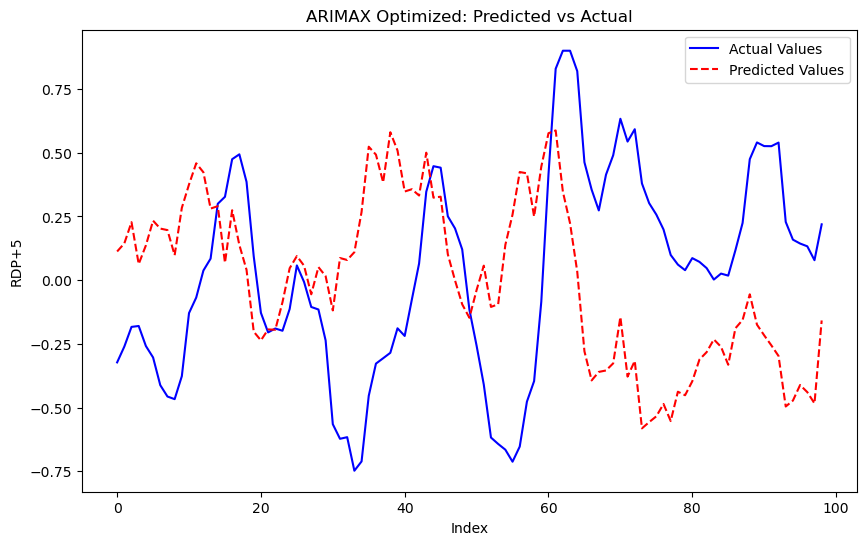

In [105]:
plot_predictions(y_test, amimax_optimized_results['best_model'].forecast(steps=len(test_data), exog=X_test), name_model = "ARIMAX Optimized", start_idx=-100, end_idx=-1)

## **Backpropagation (Neural Network)**

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K

# Define NMSE metric
def nmse_metric(y_true, y_pred):
    """
    Custom metric to calculate Normalized Mean Squared Error (NMSE).
    
    NMSE = MSE / Variance(y_true)
    """
    mse = K.mean(K.square(y_true - y_pred))
    var = K.var(y_true)
    return mse / var

In [95]:
# Backpropagation Neural Network Model
def run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32):
    """
    Fit and evaluate a Backpropagation neural network model.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - epochs (int): Number of epochs for training.
    - batch_size (int): Batch size for training.

    Returns:
    - dict: Neural network model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features].values
    y_train = train_data[target].values

    X_val = val_data[features].values
    y_val = val_data[target].values

    X_test = test_data[features].values
    y_test = test_data[target].values

    # Normalize the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

        # Build the model
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model with nmse_metric as the loss function
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[nmse_metric])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
)

    # Evaluate on the test set
    test_predictions = model.predict(X_test).flatten()
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)

    print(f"Backpropagation Test MSE: {test_mse:.4f}")
    print(f"Backpropagation Test R²: {test_r2:.4f}")
    print(f"Backpropagation Test NMSE: {test_nmse:.4f}")

    return {
        "model": model,
        "history": history,
        "predictions": test_predictions,
        "mse": test_mse,
        "r2": test_r2,
        "nmse": test_nmse
    }

In [96]:
# Run Backpropagation
backprop_results = run_backpropagation(train_data, val_data, test_data, features, target, epochs=50, batch_size=32)

Epoch 1/50
105/105 - 2s - 17ms/step - loss: 0.1343 - nmse_metric: inf - val_loss: 0.1605 - val_nmse_metric: 1.3240
Epoch 2/50
105/105 - 0s - 3ms/step - loss: 0.1341 - nmse_metric: inf - val_loss: 0.1568 - val_nmse_metric: 1.2494
Epoch 3/50
105/105 - 0s - 3ms/step - loss: 0.1320 - nmse_metric: inf - val_loss: 0.1549 - val_nmse_metric: 1.2351
Epoch 4/50
105/105 - 0s - 3ms/step - loss: 0.1316 - nmse_metric: inf - val_loss: 0.1571 - val_nmse_metric: 1.2794
Epoch 5/50
105/105 - 0s - 3ms/step - loss: 0.1311 - nmse_metric: inf - val_loss: 0.1579 - val_nmse_metric: 1.2969
Epoch 6/50
105/105 - 0s - 3ms/step - loss: 0.1312 - nmse_metric: inf - val_loss: 0.1547 - val_nmse_metric: 1.2472
Epoch 7/50
105/105 - 0s - 2ms/step - loss: 0.1315 - nmse_metric: inf - val_loss: 0.1550 - val_nmse_metric: 1.2681
Epoch 8/50
105/105 - 0s - 2ms/step - loss: 0.1303 - nmse_metric: inf - val_loss: 0.1532 - val_nmse_metric: 1.2336
Epoch 9/50
105/105 - 0s - 2ms/step - loss: 0.1302 - nmse_metric: inf - val_loss: 0.1544

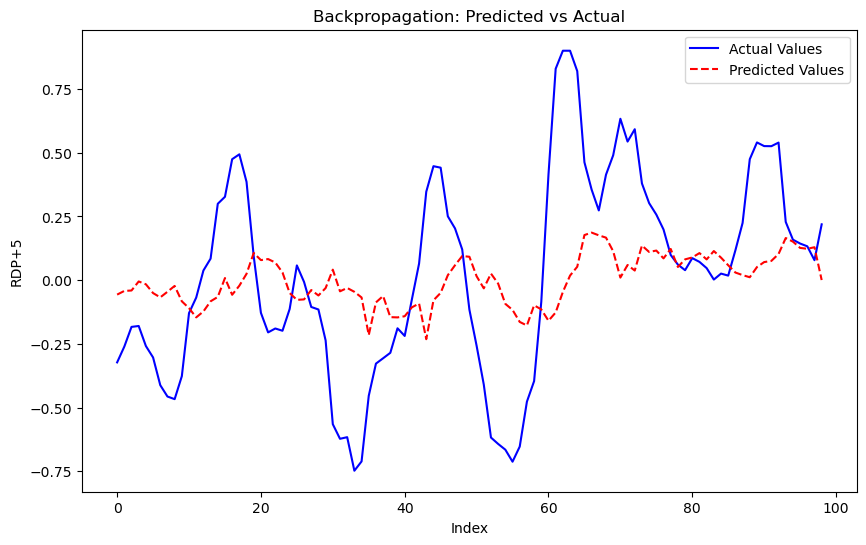

In [97]:
plot_predictions(y_test,backprop_results['predictions'], name_model = "Backpropagation", start_idx=-100, end_idx=-1)

## **Comparison of the models**

In [107]:
print("SVM Regression: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(svr_optimized_results['mse'], svr_optimized_results['r2'],svr_optimized_results['best_nmse'] ))
print("ARIMAX: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(amimax_optimized_results['mse'], amimax_optimized_results['r2'], amimax_optimized_results['best_nmse']))
print("Backpropagation: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(backprop_results['mse'], backprop_results['r2'], backprop_results['nmse']))

SVM Regression: MSE = 0.1513, R² = 0.0542, NMSE = 0.9458
ARIMAX: MSE = 0.2942, R² = -0.8384, NMSE = 1.8384
Backpropagation: MSE = 0.1725, R² = 0.0068, NMSE = 0.9932
